In [129]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras import utils,losses,layers,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard


In [130]:
import pandas as pd
data_path="./beijing2.csv"
dataset=pd.read_csv(data_path, parse_dates=["dates"],index_col=False)
dataset=dataset.set_index(dataset.columns[0])
# dataset=pd.read_csv(data_path)
dataset.shape#输出数组形状(420551, 14)（行，列）
dataset.tail()#输出尾5个列


,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
dates,,,,,,,,,,,,,,,,,,,,,
2021-01-07 14:00:00,29.9,748.5,751.3,-0.6,60,从南方吹来的风,3,NaN,8.0,90 或者更多，但不为100%,...,NaN,NaN,10.0,21.3,0.4,12.0,NaN,NaN,NaN,NaN
2021-01-07 11:00:00,23.9,749.1,751.9,-1.0,81,从东北方吹来的风,1,NaN,8.0,100%.,...,NaN,NaN,6.0,20.4,0.2,12.0,NaN,NaN,NaN,NaN
2021-01-07 08:00:00,23.7,750.1,752.8,0.3,75,从西南方吹来的风,2,NaN,NaN,90 或者更多，但不为100%,...,NaN,NaN,12.0,19.0,3.0,12.0,NaN,NaN,NaN,NaN
2021-01-07 05:00:00,20.1,749.8,752.6,0.3,87,从北方吹来的风,1,NaN,11.0,20–30%.,...,NaN,NaN,13.0,17.9,3.0,12.0,NaN,NaN,NaN,NaN
2021-01-07 02:00:00,20.3,749.5,752.3,-0.3,87,从东南偏南方向吹来的风,1,NaN,11.0,NaN,...,NaN,NaN,26.0,18.1,3.0,12.0,NaN,NaN,NaN,NaN


In [131]:
dataset.head()#数据结构如下，输出头5个列
dataset.columns

Index(['T', 'Po', 'P', 'Pa', 'U', 'DD', 'Ff', 'ff10', 'ff3', 'N', 'WW', 'W1',
       'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'VV', 'Td', 'RRR', 'tR',
       'E', 'Tg', 'E'', 'sss'],
      dtype='object')

In [132]:
df=dataset[['T','Po','U']]
df.head()
df.info()
df.columns=['Temp','pressure','Humidity']
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3078 entries, 2022-07-22 17:00:00 to 2021-01-07 02:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       3078 non-null   float64
 1   Po      3078 non-null   float64
 2   U       3078 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 96.2 KB


,Temp,pressure,Humidity
dates,,,
2022-07-22 17:00:00,30.1,751.0,62
2022-07-22 14:00:00,30.2,752.1,62
2022-07-22 11:00:00,30.9,752.8,55
2022-07-22 08:00:00,27.3,753.3,82
2022-07-22 05:00:00,24.6,753.0,96


In [133]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df['month']=df.index.month
df['hour']=df.index.hour
df.head()

D:\Programming\HelpPlugins\Anaconda\Download\envs\temp_pred\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Programming\HelpPlugins\Anaconda\Download\envs\temp_pred\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Temp,pressure,Humidity,month,hour
dates,,,,,
2022-07-22 17:00:00,30.1,751.0,62,7,17
2022-07-22 14:00:00,30.2,752.1,62,7,14
2022-07-22 11:00:00,30.9,752.8,55,7,11
2022-07-22 08:00:00,27.3,753.3,82,7,8
2022-07-22 05:00:00,24.6,753.0,96,7,5


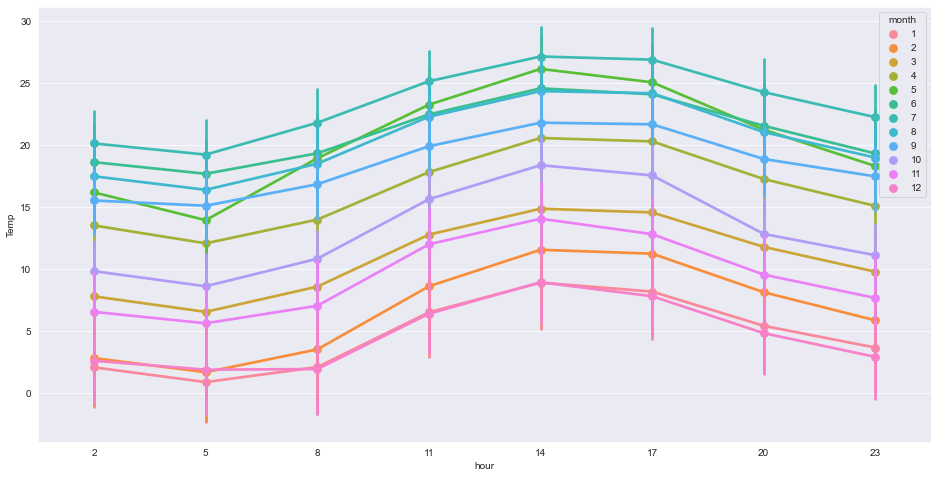

In [134]:

plt.figure(figsize=(16,8))
sns.pointplot(x='hour',y='Temp',data=df[:],hue='month')
plt.show()


In [135]:
df['sin(h)']=[np.sin((x) * (2 * np.pi / 24)) for x in df['hour']]
df['cos(h)']=[np.cos((x) * (2 * np.pi / 24)) for x in df['hour']]

D:\Programming\HelpPlugins\Anaconda\Download\envs\temp_pred\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\HelpPlugins\Anaconda\Download\envs\temp_pred\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [136]:

def multivariate_data(x,y, start_index, end_index, history_size,
                      target_size, step, single_step):

    #single_step意思是只预测目标的一个未来状态，只预测后1小时，设置为false可以预测未来0到target_size小时内的温度。
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(x) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) # step表示滑动步长
        # print(indices)
        mid_data=x.iloc[indices]
        data.append(mid_data)

        if single_step:
            mid_data=y.iloc[i+target_size]
            labels.append(mid_data)
        else:
            labels.append(y.iloc[i:i+target_size])

    return np.array(data), np.array(labels)

In [137]:
from sklearn.preprocessing import MinMaxScaler
future=['sin(h)','cos(h)','month','Temp','pressure','Humidity']
#数据归一化，由于sin和cos本来就是-1到1，不用归一化
for col in future:
    scaler=MinMaxScaler()
    if(col not in ['sin(h)','cos(h)']):
    	df[col]=scaler.fit_transform(df[col].values.reshape(-1,1))

D:\Programming\HelpPlugins\Anaconda\Download\envs\temp_pred\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Programming\HelpPlugins\Anaconda\Download\envs\temp_pred\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Programming\HelpPlugins\Anaconda\Download\envs\temp_pred\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [138]:
x=df[future]
y=df['Temp']
#查看具体格式
x.shape
y.shape


(3078,)

In [139]:
from sklearn.model_selection import train_test_split
#通过3-7划分训练集和测试集，70%为训练集
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False,random_state=13)


In [140]:

y_train.shape


(2154,)

In [141]:

#取得训练集，和测试集的格式——》(3,6)->(1,)通过3行历史数据7列目标特征预测1行1列的目标
# train_dataset,train_labels=multivariate_data(x_train,y_train,0,100000,3,1,1,True)
# test_dataset,test_labels=multivariate_data(x_test,y_test,0,100000,3,1,1,True)
train_dataset,train_labels=multivariate_data(x_train,y_train,0,None,24,1,1,False)
test_dataset,test_labels=multivariate_data(x_test,y_test,0,None,24,1,1,False)


In [142]:
x=df[future]
y=df['Temp']
#查看具体格式
x.shape
train_dataset.shape[-2:]

(24, 6)

In [143]:
def create_batch_dataset(x,y,train=True,buffer_size=1000,batch_size=128):
    batch_data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    if train:
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else:
        return batch_data.batch(batch_size)
       
        
#使用上面函数
train_batch_dataset=create_batch_dataset(train_dataset,train_labels)
test_batch_dataset=create_batch_dataset(test_dataset,test_labels,train=False)
#拿一个测试集元素查看格式
list(test_batch_dataset.as_numpy_iterator())[0]
print(train_batch_dataset)
print(test_batch_dataset)

<BatchDataset shapes: ((None, 24, 6), (None, 1)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, 24, 6), (None, 1)), types: (tf.float64, tf.float64)>


In [144]:
model= tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, input_shape=train_dataset.shape[-2:],return_sequences=True), # input_shape=(20,1) 不包含批处理维度
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

#优化器和损失函数设置
model.compile(optimizer='adam',loss='mse')

#模型保存的相关设置
utils.plot_model(model)
checkpoint_file='test_model.hdf5'
checkpoint_callback=ModelCheckpoint(filepath=checkpoint_file,monitor='loss',moode='min',save_best_only=True,save_weights_only=True)
#模型训练
history=model.fit(train_batch_dataset,epochs=30,validation_data=test_batch_dataset,callbacks=[checkpoint_callback])

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/30
17/17 [==============================] - 7s 245ms/step - loss: 0.0598 - val_loss: 0.0051
Epoch 2/30
17/17 [==============================] - 4s 208ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 3/30
17/17 [==============================] - 3s 206ms/step - loss: 0.0073 - val_loss: 0.0037
Epoch 4/30
17/17 [==============================] - 3s 206ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 5/30
17/17 [==============================] - 3s 208ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 6/30
17/17 [==============================] - 4s 209ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 7/30
17/17 [==============================] - 3s 205ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 8/30
17/17 [==============================] - 3s 205ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 9/30
17/17 [============

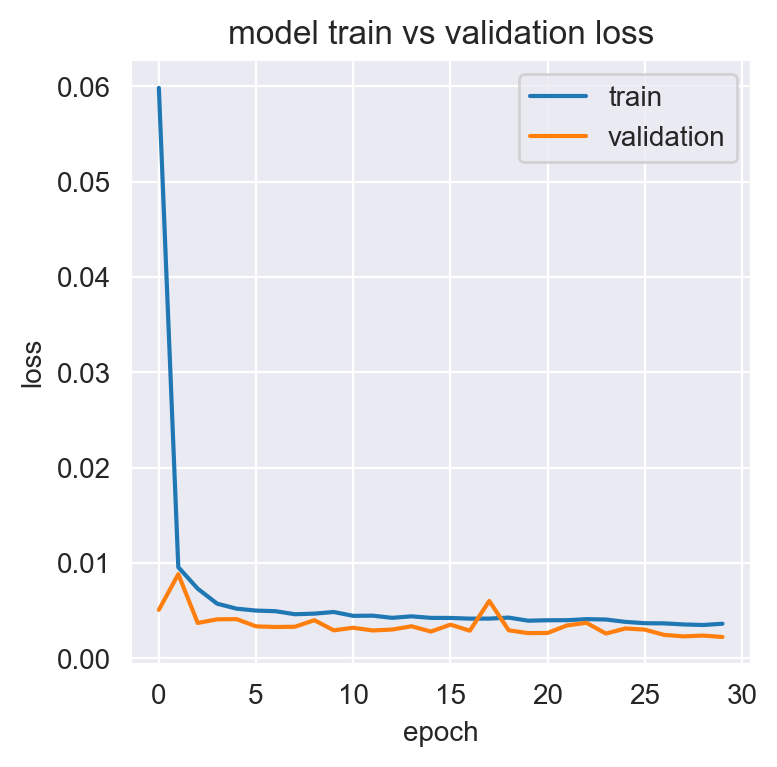

In [145]:
plt.figure(figsize=(4,4),dpi=200)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.show()

In [146]:
test_dataset.shape

(899, 24, 6)

In [147]:
#通过输入一组数据预测
test_preds=model.predict(test_dataset,verbose=1,batch_size=1)
test_preds[:10]

899/899 [==============================] - 3s 3ms/step


array([[0.5048441 ],
       [0.4616065 ],
       [0.40036052],
       [0.36540407],
       [0.372068  ],
       [0.41750592],
       [0.4908899 ],
       [0.55018115],
       [0.561704  ],
       [0.51139265]], dtype=float32)

In [148]:
#将预测后的一组数据转化为1维方便比较
# test_preds=test_preds[:,0]
# test_preds[:10]
test_preds.shape
test_preds[:10]

array([[0.5048441 ],
       [0.4616065 ],
       [0.40036052],
       [0.36540407],
       [0.372068  ],
       [0.41750592],
       [0.4908899 ],
       [0.55018115],
       [0.561704  ],
       [0.51139265]], dtype=float32)

In [149]:
test_labels.shape
test_labels[:10]

array([[0.58467742],
       [0.54435484],
       [0.44556452],
       [0.30846774],
       [0.3608871 ],
       [0.50806452],
       [0.40524194],
       [0.58669355],
       [0.60685484],
       [0.55846774]])

0.8535107774322421


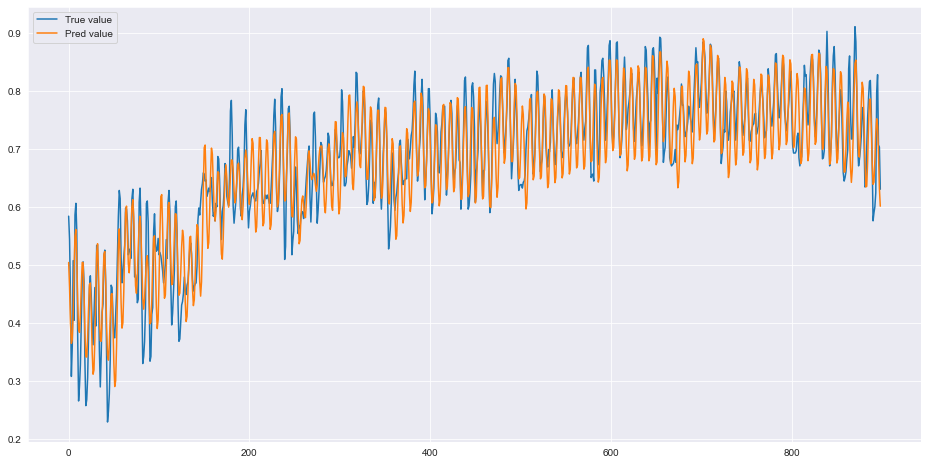

In [150]:
#r2检验，越接近1效果越好，负数表示完全没用......
score=r2_score(test_labels,test_preds)
print(score)

#做出预测结果和实际结果的曲线对比，使用1000次结果对比
plt.figure(figsize=(16,8))
plt.plot(test_labels[:1000],label="True value")
plt.plot(test_preds[:1000],label="Pred value")
plt.legend(loc='best')
plt.show()